In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
import itertools
import importlib
import time

In [2]:
from training import toy
importlib.reload(toy)
torch.manual_seed(42)

batch_size = 2

trainset = toy.TwoMoonsDataset(samples=100, noise=0.1, seed=42)
#trainset = toy.TrigonometricToyDataset(sample_count=200, normalize=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

device = torch.device("cpu")

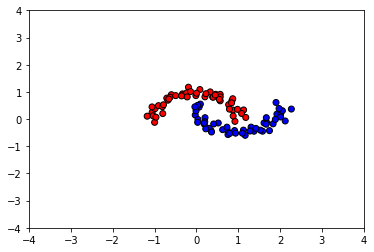

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

eval_points = 100
sample_cmap = ListedColormap(["red", "blue"])
area_cmap = plt.cm.RdBu
variance_cmap = plt.cm.viridis
xlim = 4
ylim = 4

def plot_samples(ax):
    data, labels = zip(*trainset)
    ax.scatter(*zip(*data), c=labels, cmap=sample_cmap, edgecolors="black")

def plot(name, eval):
    with torch.no_grad():
        fig, (value_ax, var_ax) = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(name)
        value_ax.set_xlim(-xlim, xlim)
        value_ax.set_ylim(-ylim, ylim)
        var_ax.set_xlim(-xlim, xlim)
        var_ax.set_ylim(-ylim, ylim)
        
        xs, ys = np.meshgrid(np.linspace(-xlim, xlim, eval_points), np.linspace(-ylim, ylim, eval_points))
        data = np.dstack((xs.reshape(eval_points * eval_points), ys.reshape(eval_points * eval_points)))[0]
        results, variances = eval(torch.from_numpy(data).float())
        results, variances = results.detach().numpy().reshape(eval_points, eval_points), variances.detach().numpy().reshape(eval_points, eval_points)
        value_ax.contourf(xs, ys, results, 100, cmap=area_cmap)
        var_ax.contourf(xs, ys, np.sqrt(variances), 100, cmap=variance_cmap, vmin=0, vmax=1.0)

        results = torch.round(eval(trainset.samples)[0])
        corrects = (results == trainset.labels).sum()
        print(f"Total accuracy {corrects / (len(trainloader) * batch_size)}")

        value_ax.scatter(*zip(*trainset.samples), facecolors=sample_cmap(results), edgecolors=sample_cmap(trainset.labels))

fig = plt.axes()
fig.set_xlim(-xlim, xlim)
fig.set_ylim(-ylim, ylim)
plot_samples(fig)

Epoch 0: loss 0.3477148413658142
Epoch 10: loss 0.28273847699165344
Epoch 20: loss 0.17971090972423553
Epoch 30: loss 0.15042966604232788
Epoch 40: loss 0.13818344473838806
Epoch 50: loss 0.1314569115638733
Epoch 60: loss 0.12219800055027008
Epoch 70: loss 0.12013473361730576
Epoch 80: loss 0.11096625030040741
Epoch 90: loss 0.10307478904724121
Final loss 0.08510102331638336
Total accuracy 0.9200000166893005


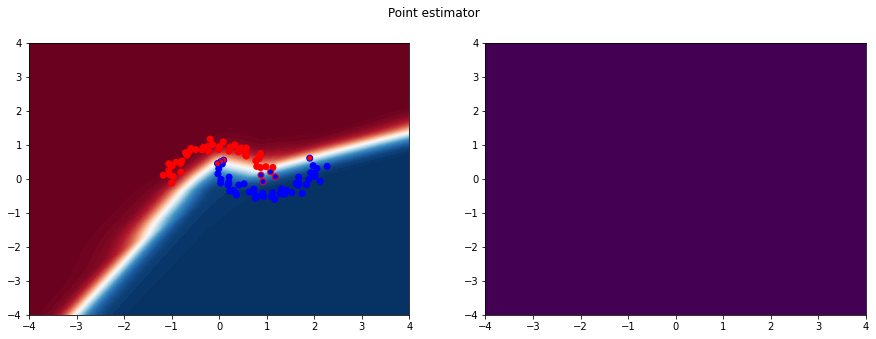

In [123]:
# Point estimator with L2 regularization

torch.manual_seed(42)

model = nn.Sequential(
    nn.Linear(2, 16), 
    nn.ReLU(), 
    nn.Linear(16, 16), 
    nn.ReLU(),
    nn.Linear(16, 16), 
    nn.ReLU(), 
    nn.Linear(16, 1),
    nn.Sigmoid()
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
for epoch in range(100):
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")
plot("Point estimator", lambda input: (model(input), torch.zeros(input.shape[0])))

Epoch 0: loss 0.3477148413658142
Epoch 10: loss 0.28273847699165344
Epoch 20: loss 0.17971090972423553
Epoch 30: loss 0.15042966604232788
Epoch 40: loss 0.13818344473838806
Epoch 50: loss 0.1314569115638733
Epoch 60: loss 0.12219800055027008
Epoch 70: loss 0.12013473361730576
Epoch 80: loss 0.11096625030040741
Epoch 90: loss 0.10307478904724121
Final loss 0.08510102331638336
Total accuracy 0.8999999761581421


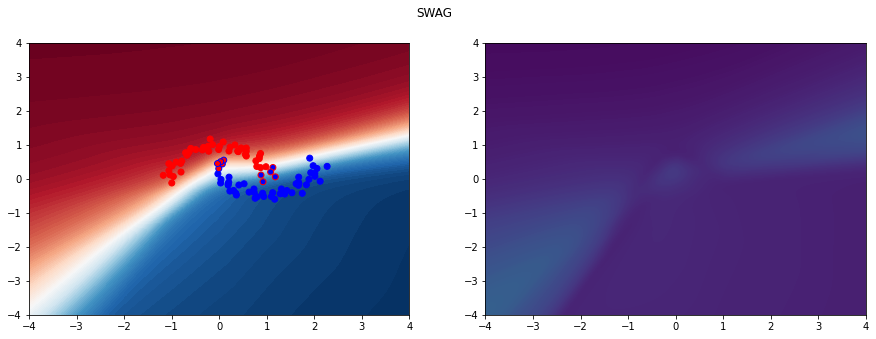

In [48]:
# SWAG trained with SGD and L2 regularization (lr is currently not adjusted for SWAG)

from training import swag
importlib.reload(swag)

torch.manual_seed(42)

model = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001) # Without weight_decay the covariance matrix is not positive definit???
wrapper = swag.SWAGWrapper(model, 1, 10)
for epoch in range(100):
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    wrapper.update(epoch)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_swag(input):
    torch.manual_seed(42)
    results, vars = wrapper.sample(input, 100, model, 1)
    return results, vars
plot("SWAG", eval_swag)

Training model 0
  Final loss 0.08712420612573624
Training model 1
  Final loss 0.017180245369672775
Training model 2
  Final loss 0.048330795019865036
Training model 3
  Final loss 0.0651736781001091
Training model 4
  Final loss 0.03897734358906746
Total accuracy 0.9800000190734863


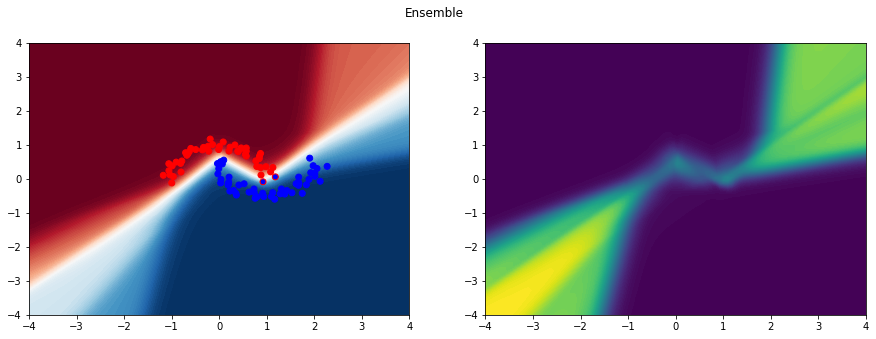

In [70]:
# Ensemble of point estimators with L2 regularization

from training import ensemble
importlib.reload(ensemble)

torch.manual_seed(42)

ensemble_count = 5
models = [nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
) for _ in range(ensemble_count)]

for i, model in enumerate(models):
    print(f"Training model {i}")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
    for epoch in range(100):
        epoch_loss = torch.tensor(0, dtype=torch.float)
        for data, target in trainloader:
            optimizer.zero_grad()
            output = model(data)
            loss = F.binary_cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss
        #if epoch % 10 == 0:
            #print(f"  Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
    print(f"  Final loss {epoch_loss / (len(trainloader) * batch_size)}")


def eval_esemble(input):
    outputs = torch.stack([model(input) for model in models])
    return outputs.mean(dim=0), outputs.var(dim=0)
plot("Ensemble", eval_esemble)

Epoch 0: loss 11.561352729797363
Epoch 10: loss 11.56119155883789
Epoch 20: loss 11.559497833251953
Epoch 30: loss 11.557974815368652
Epoch 40: loss 11.55813217163086
Epoch 50: loss 11.555538177490234
Epoch 60: loss 11.556735038757324
Epoch 70: loss 11.554361343383789
Epoch 80: loss 11.555464744567871
Epoch 90: loss 11.554386138916016
Final loss 11.553282737731934


C:\Users\flose\.conda\envs\ml\lib\site-packages\matplotlib\contour.py:1486: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\flose\.conda\envs\ml\lib\site-packages\matplotlib\contour.py:1487: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


Total accuracy 0.5


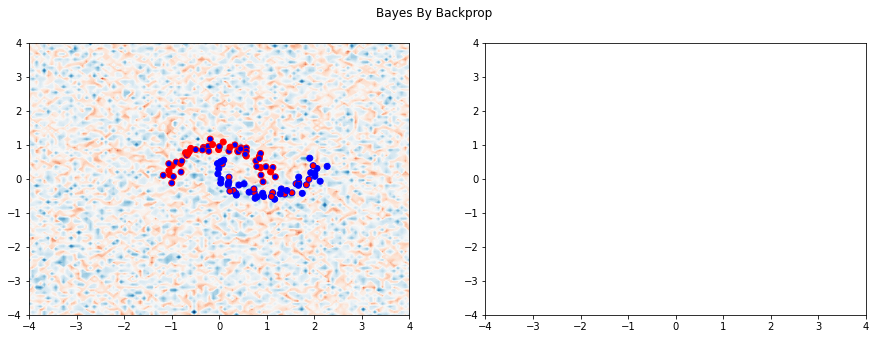

In [16]:
# Bayesian NN (Bayes-by-Backprop)

from training import bbb, util
importlib.reload(bbb)
importlib.reload(util)

torch.manual_seed(42)

pi = 0.5  # 0.25, 0.5, 0.75
sigma1 = np.exp(-1)  # 0, 1, 2
sigma2 = np.exp(-7)  # 6, 7, 8
# log_prob of the mixture is about 2x slower than that of Normal
#prior = util.GaussianMixture(pi, sigma1, sigma2)
prior = torch.distributions.Normal(0, 1.0)

model = nn.Sequential(
    bbb.BBBLinear(2, 16, prior, prior, device, mc_sample=5),
    nn.ReLU(),
    bbb.BBBLinear(16, 16, prior, prior, device, mc_sample=5),
    nn.ReLU(),
    bbb.BBBLinear(16, 16, prior, prior, device, mc_sample=5),
    nn.ReLU(),
    bbb.BBBLinear(16, 1, prior, prior, device, mc_sample=5),
    nn.Sigmoid()
)

model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCELoss()

for epoch in range(100):
    loss = bbb.run_bbb_epoch(model, optimizer, loss_fn, trainloader, device)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {loss / (len(trainloader) * batch_size)}")
print(f"Final loss {loss / (len(trainloader) * batch_size)}")


def eval_bbb(input):
    samples = 1
    model.eval()
    outputs = torch.stack([model(input) for _ in range(samples)])
    return torch.mean(outputs, dim=0), torch.var(outputs, dim=0)
plot("Bayes By Backprop", eval_bbb)

Epoch 0: loss 0.3456931710243225
Epoch 10: loss 0.30028483271598816
Epoch 20: loss 0.20247262716293335
Epoch 30: loss 0.18934044241905212
Epoch 40: loss 0.14290647208690643
Epoch 50: loss 0.19673824310302734
Epoch 60: loss 0.14381395280361176
Epoch 70: loss 0.15262041985988617
Epoch 80: loss 0.1331617832183838
Epoch 90: loss 0.1309162676334381
Final loss 0.1207856684923172
Total accuracy 0.9300000071525574


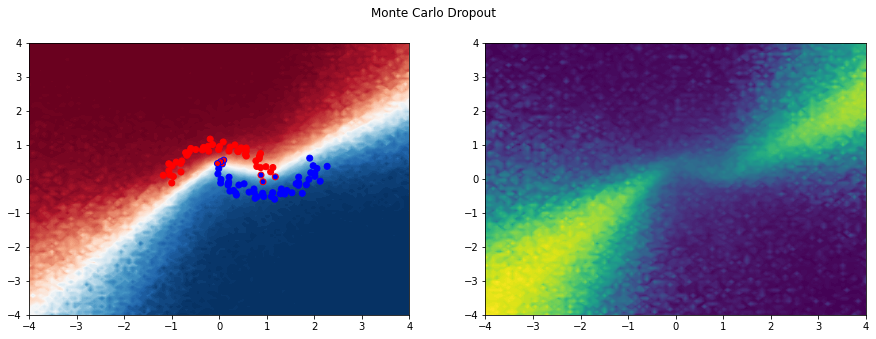

In [79]:
# MC dropout

torch.manual_seed(42)

p = 0.3

model = nn.Sequential(
    # It seems to be counterproductive to drop inputs because there are only 2 inputs
    nn.Linear(2, 32), 
    nn.ReLU(), 
    nn.Dropout(p),
    nn.Linear(32, 32), 
    nn.ReLU(),
    nn.Dropout(p),
    nn.Linear(32, 32), 
    nn.ReLU(), 
    nn.Dropout(p),
    nn.Linear(32, 1),
    nn.Sigmoid()
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(100):
    model.train()
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_dropout(input):
    samples = 100
    model.train() # Enable dropout
    outputs = torch.stack([model(input) for _ in range(samples)])
    return torch.mean(outputs, dim=0), torch.var(outputs, dim=0)

plot("Monte Carlo Dropout", eval_dropout)

Epoch 0: loss 4.944335460662842
Epoch 10: loss 1.0442137718200684
Epoch 20: loss 0.7914572954177856
Epoch 30: loss 0.7325028777122498
Epoch 40: loss 0.723812460899353
Epoch 50: loss 0.6407654285430908
Epoch 60: loss 0.5669166445732117
Epoch 70: loss 0.6199315190315247
Epoch 80: loss 0.5548806190490723
Epoch 90: loss 0.5896300673484802
Final loss 0.48991021513938904
Total accuracy 0.8299999833106995


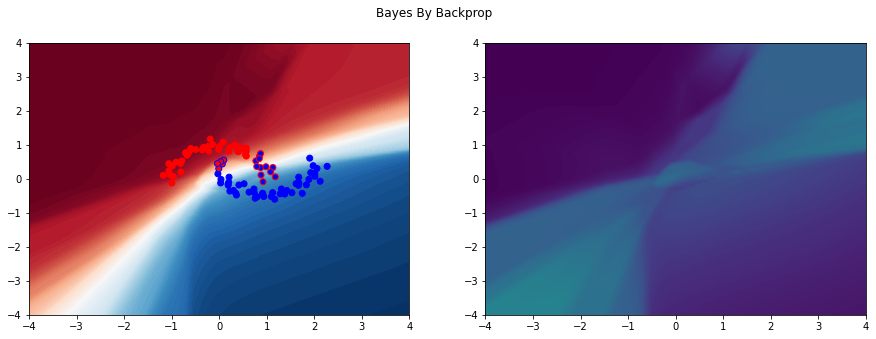

In [49]:
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss

torch.manual_seed(42)

const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",
        "moped_enable": False,
        "moped_delta": 0.5,
}

model = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

dnn_to_bnn(model, const_bnn_prior_parameters)

optimizer = torch.optim.Adam(model.parameters(), 0.01)
for epoch in range(100):
    model.train()
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = get_kl_loss(model) / batch_size + F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")


def eval_bayes(input):
    samples = 10
    model.eval()
    outputs = torch.stack([model(input) for _ in range(samples)])
    return torch.mean(outputs, dim=0), torch.var(outputs, dim=0)
plot("Bayes By Backprop", eval_bayes)